<a href="https://colab.research.google.com/github/rabiul-ai/Arrhythmia_Classification/blob/main/Arrhythmia_Classification_Full_and_Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Phân loại rối loạn nhịp tim ECG đơn kênh**



## **a. Tóm tắt**


*   **Nhiệm vụ:** Phân loại 5 loại rối loạn nhịp tim
*   **Dataset:** MIT-BIH, Dataset website: [Here](https://physionet.org/content/mitdb/1.0.0/)
*   **Model:** CNN_LSTM + Attention

## **b. Thông tin về Datasets sử dụng:**

Datasets có thể tải từ: [website](https://physionet.org/content/mitdb/1.0.0/) hoặc: [link](https://physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip). Thông tin tổng quan về bộ datasets này ở: [here](https://archive.physionet.org/physiobank/database/html/mitdbdir/intro.htm).
1. Bộ dữ liệu MIT-BIH bao gồm **48 bản ghi**.
2. **Số bệnh nhân = 47** (25 nam, 22 nữ). Chỉ 1 bệnh nhân có 2 bản ghi.
3. Mỗi bản ghi bao gồm a. tín hiệu ECG b. Annotations
4. Độ dài tín hiệu ECG = **30 phút**. Tần số lấy mẫu = **360 Hz**. 
5. Mỗi bản ghi bao gồm **2 Lead ECG** là Modified Limb Lead II và Modified Lead V1 (**MLII, V1**).
6. Annotation được chú thích cho từng nhịp tim. Mặc dù có 20 loại annotation được chú thích, ta chỉ xét 15 loại, và được chia vào 5 loại chính theo tiêu chuẩn của **AAMI**.
* N - Bình thường
* S - Nhịp ngoại tâm thu trên thất
* V - Ngoại tâm thu thất
* F - Nhịp hòa hợp (giữa nhịp thất và nhịp bình thường)
* Q - Nhịp không thể phân loại / Nhịp không rõ

# **Các phần chính trong code này:** 

1.   **Phần A: Cài đặt thư viện và trực quan hóa cơ bản tín hiệu ECG**
2.   **Phần B: Khử nhiễu, phát hiện đỉnh R (R-Peak), và cắt nhịp**
3.   **Phần C: Nạp dữ liệu**
4.   **Phần D: Chia dữ liệu Train/Test và cân bằng lớp**
5.   **Phần E: Xây dựng mô hình và huấn luyện**
6.   **Phần F: Hiển thị kết quả**

# **Phần A: Cài đặt thư viện và trực quan hóa cơ bản tín hiệu ECG**

## **A1: Tải các gói cần thiết**

In [ ]:
# wfdb is not normally installed in Colab
!pip install seaborn 

In [2]:
# Importing packages
import os
import datetime
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import pandas as pd

## **A2: Trực quan hóa tín hiệu ECG**
Code cho phần loading (reading), plottin tín hiệu ECG

Vẽ tín hiệu ECG đo được của ông hôm nọ ở viện

Tổng số bản ghi trong file: 81
Đang hiển thị bản ghi ID: 76, độ dài tín hiệu: 1250 mẫu


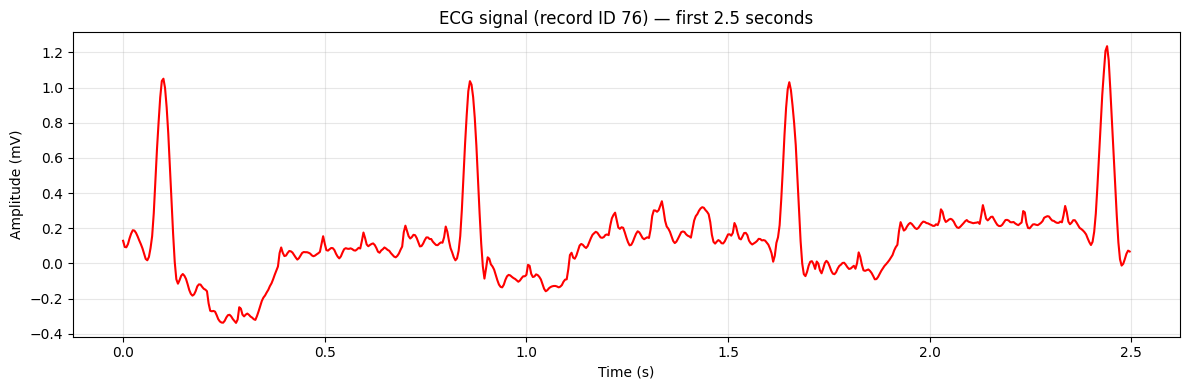

In [6]:
#Đo với tần số lấy mẫu = 250 Hz
#Vẽ tín hiệu ECG của ông hôm nọ vùa đi đo về
import json
# 1️⃣ Đọc file JSON
with open("../my datasets/readings_with_id.json", "r") as f:
    data = json.load(f)

print(f"Tổng số bản ghi trong file: {len(data)}")

# 2️⃣ Lấy bản ghi đầu tiên để hiển thị
record = data[75]
record_id = record["id"]
readings = np.array(record["reading"])
print(f"Đang hiển thị bản ghi ID: {record_id}, độ dài tín hiệu: {len(readings)} mẫu")

# 3️⃣ Nếu tín hiệu quá dài, chỉ lấy một đoạn (ví dụ 10 giây)
fs = 250  # tần số lấy mẫu (Hz) — điều chỉnh nếu khác
seconds_to_show = 2.5
samples_to_show = int(fs * seconds_to_show)
segment = readings[:samples_to_show]

# 4️⃣ Tạo trục thời gian
time_axis = np.arange(len(segment)) / fs

# 5️⃣ Vẽ 1 figure duy nhất
plt.figure(figsize=(12, 4))
plt.plot(time_axis, segment, color="red")
plt.title(f"ECG signal (record ID {record_id}) — first {seconds_to_show} seconds")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# **Phần B: Khử nhiễu, phát hiện đỉnh R (R-Peak), và cắt nhịp** 

### **B1: Khử nhiễu**
dùng Discrete Wavelet Transform (DCT)

In [7]:
# User defined fucntion for DWT and reconstruction
def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

✅ Đã load 1250 mẫu ECG từ file test.json


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


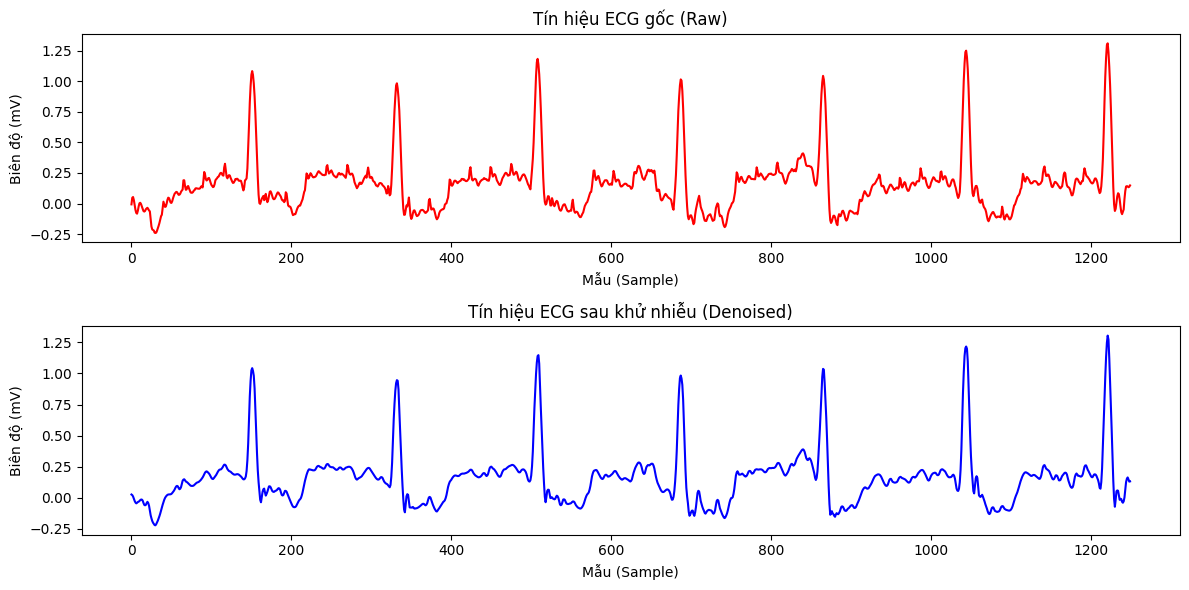

In [8]:
# 1. Load ECG signal từ file json
# === 1. Load ECG signal từ file test.json ===
with open("../my datasets/readings_with_id.json", "r") as f:
    data = json.load(f)

# Lấy mảng reading đầu tiên (giả sử chỉ có 1 bệnh nhân)
if isinstance(data, list) and len(data) > 0 and "reading" in data[70]:
    ecg = np.array(data[70]["reading"], dtype=float)
else:
    raise ValueError("Không tìm thấy trường 'reading' trong file test.json")

print(f"✅ Đã load {len(ecg)} mẫu ECG từ file test.json")

# === 2. Khử nhiễu bằng hàm denoise() có sẵn của bạn ===
ecg_denoised = denoise(ecg)

# === 3. Vẽ so sánh trước và sau khi khử nhiễu ===
plt.figure(figsize=(12, 6), dpi=100)

# Biểu đồ 1: Raw ECG
plt.subplot(2, 1, 1)
plt.plot(ecg, color='red')
plt.title("Tín hiệu ECG gốc (Raw)")
plt.xlabel("Mẫu (Sample)")
plt.ylabel("Biên độ (mV)")

# Biểu đồ 2: Denoised ECG
plt.subplot(2, 1, 2)
plt.plot(ecg_denoised, color='blue')
plt.title("Tín hiệu ECG sau khử nhiễu (Denoised)")
plt.xlabel("Mẫu (Sample)")
plt.ylabel("Biên độ (mV)")

plt.tight_layout()
plt.show()

### **B2: Phát hiện đỉnh R trong QRS**

Vị trí R peaks: [ 151  332  508  687  865 1044 1221]
Số lượng R peaks: 7


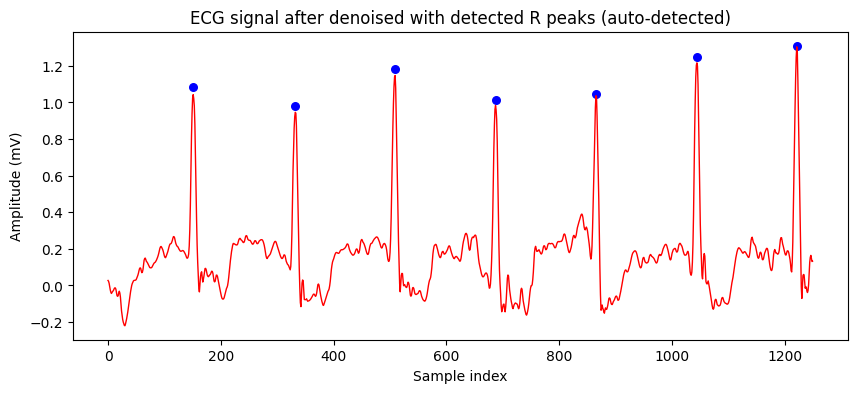

In [9]:
from scipy.signal import find_peaks

# --- Load dữ liệu test.json ---
with open("../my datasets/readings_with_id.json", "r") as f:
    data = json.load(f)

# Giả sử chỉ có 1 bệnh nhân trong file
ecg = np.array(data[70]["reading"])

# --- Tìm các đỉnh R trong tín hiệu ---
# Tham số height và distance cần điều chỉnh tùy tín hiệu
peaks, properties = find_peaks(ecg, height=0.5, distance=150)
Rlocation = peaks
Rclass = ['N'] * len(Rlocation)   # giả sử tất cả là nhịp bình thường

print("Vị trí R peaks:", Rlocation[:10])
print("Số lượng R peaks:", len(Rlocation))

# --- Vẽ kiểm tra ---
plt.figure(figsize=(10,4))
plt.plot(ecg_denoised, color='red', linewidth=1)
plt.scatter(Rlocation, ecg[Rlocation], color='blue', s=30)
plt.title("ECG signal after denoised with detected R peaks (auto-detected)")
plt.xlabel("Sample index")
plt.ylabel("Amplitude (mV)")
plt.show()

### **B3: Cắt nhịp**
Mỗi tín hiệu ECG được cắt với **độ dài cửa sổ là 99+X**. Từ đỉnh R, **99** được lấy từ phía **trái** và **X** mẫu được lấy từ phía **phải**.

Nhịp 1: từ 52 đến 250, độ dài 198 mẫu
Nhịp 2: từ 233 đến 431, độ dài 198 mẫu
Nhịp 3: từ 409 đến 607, độ dài 198 mẫu


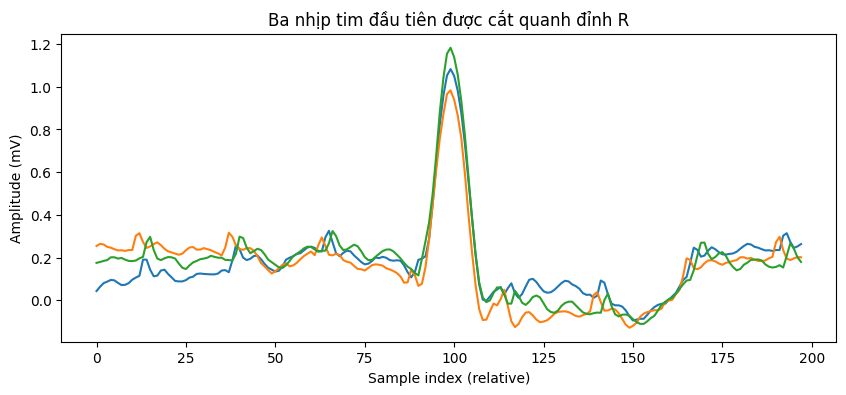

In [10]:
plt.figure(figsize=(10, 4))
for i in range(3):  # 3 nhịp đầu tiên
    start = max(Rlocation[i] - 99, 0)
    end = min(Rlocation[i] + 99, len(ecg))
    x_train = ecg[start:end]
    plt.plot(x_train)
    print(f"Nhịp {i+1}: từ {start} đến {end}, độ dài {len(x_train)} mẫu")

plt.title("Ba nhịp tim đầu tiên được cắt quanh đỉnh R")
plt.xlabel("Sample index (relative)")
plt.ylabel("Amplitude (mV)")
plt.show()

### **B4: Hoàn thành bước tiền xử lý dữ liệu**
3 phần trên được minh họa trong 1 hình

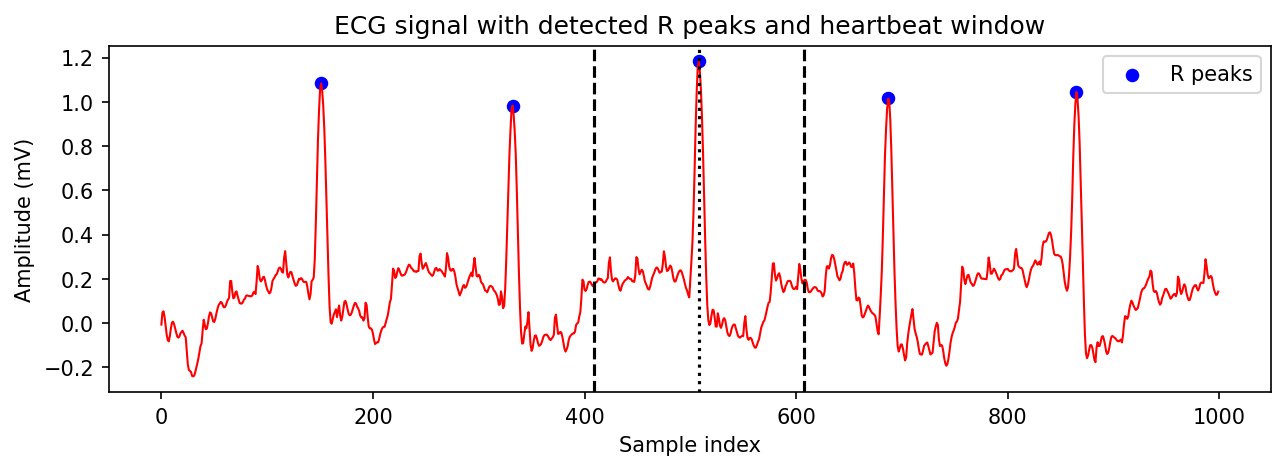

In [11]:
# Vẽ tín hiệu với đỉnh R và cửa sổ nhịp tim ---
fig = plt.figure(figsize=(10, 3), dpi=150)

# Lấy 5 đỉnh đầu tiên (nếu có)
n_peak = min(5, len(Rlocation))
r_peak_x = [Rlocation[i] for i in range(n_peak)]
r_peak_y = [ecg[Rlocation[i]] for i in range(n_peak)]

# Giới hạn hiển thị 1000 mẫu đầu tiên (để dễ xem)
x = np.arange(0, min(len(ecg), 1000))
plt.plot(x, ecg[0:len(x)], color='red', linewidth=1)
plt.scatter(r_peak_x, r_peak_y, color='blue', s=30, label='R peaks')

# Vẽ cửa sổ nhịp tim quanh đỉnh R thứ 3 (nếu đủ đỉnh)
if len(Rlocation) >= 3:
    plt.axvline(x=Rlocation[2], color='k', linestyle=':')
    plt.axvline(x=Rlocation[2]-99, color='k', linestyle='--')
    plt.axvline(x=Rlocation[2]+99, color='k', linestyle='--')

plt.title("ECG signal with detected R peaks and heartbeat window")
plt.xlabel("Sample index")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.show()

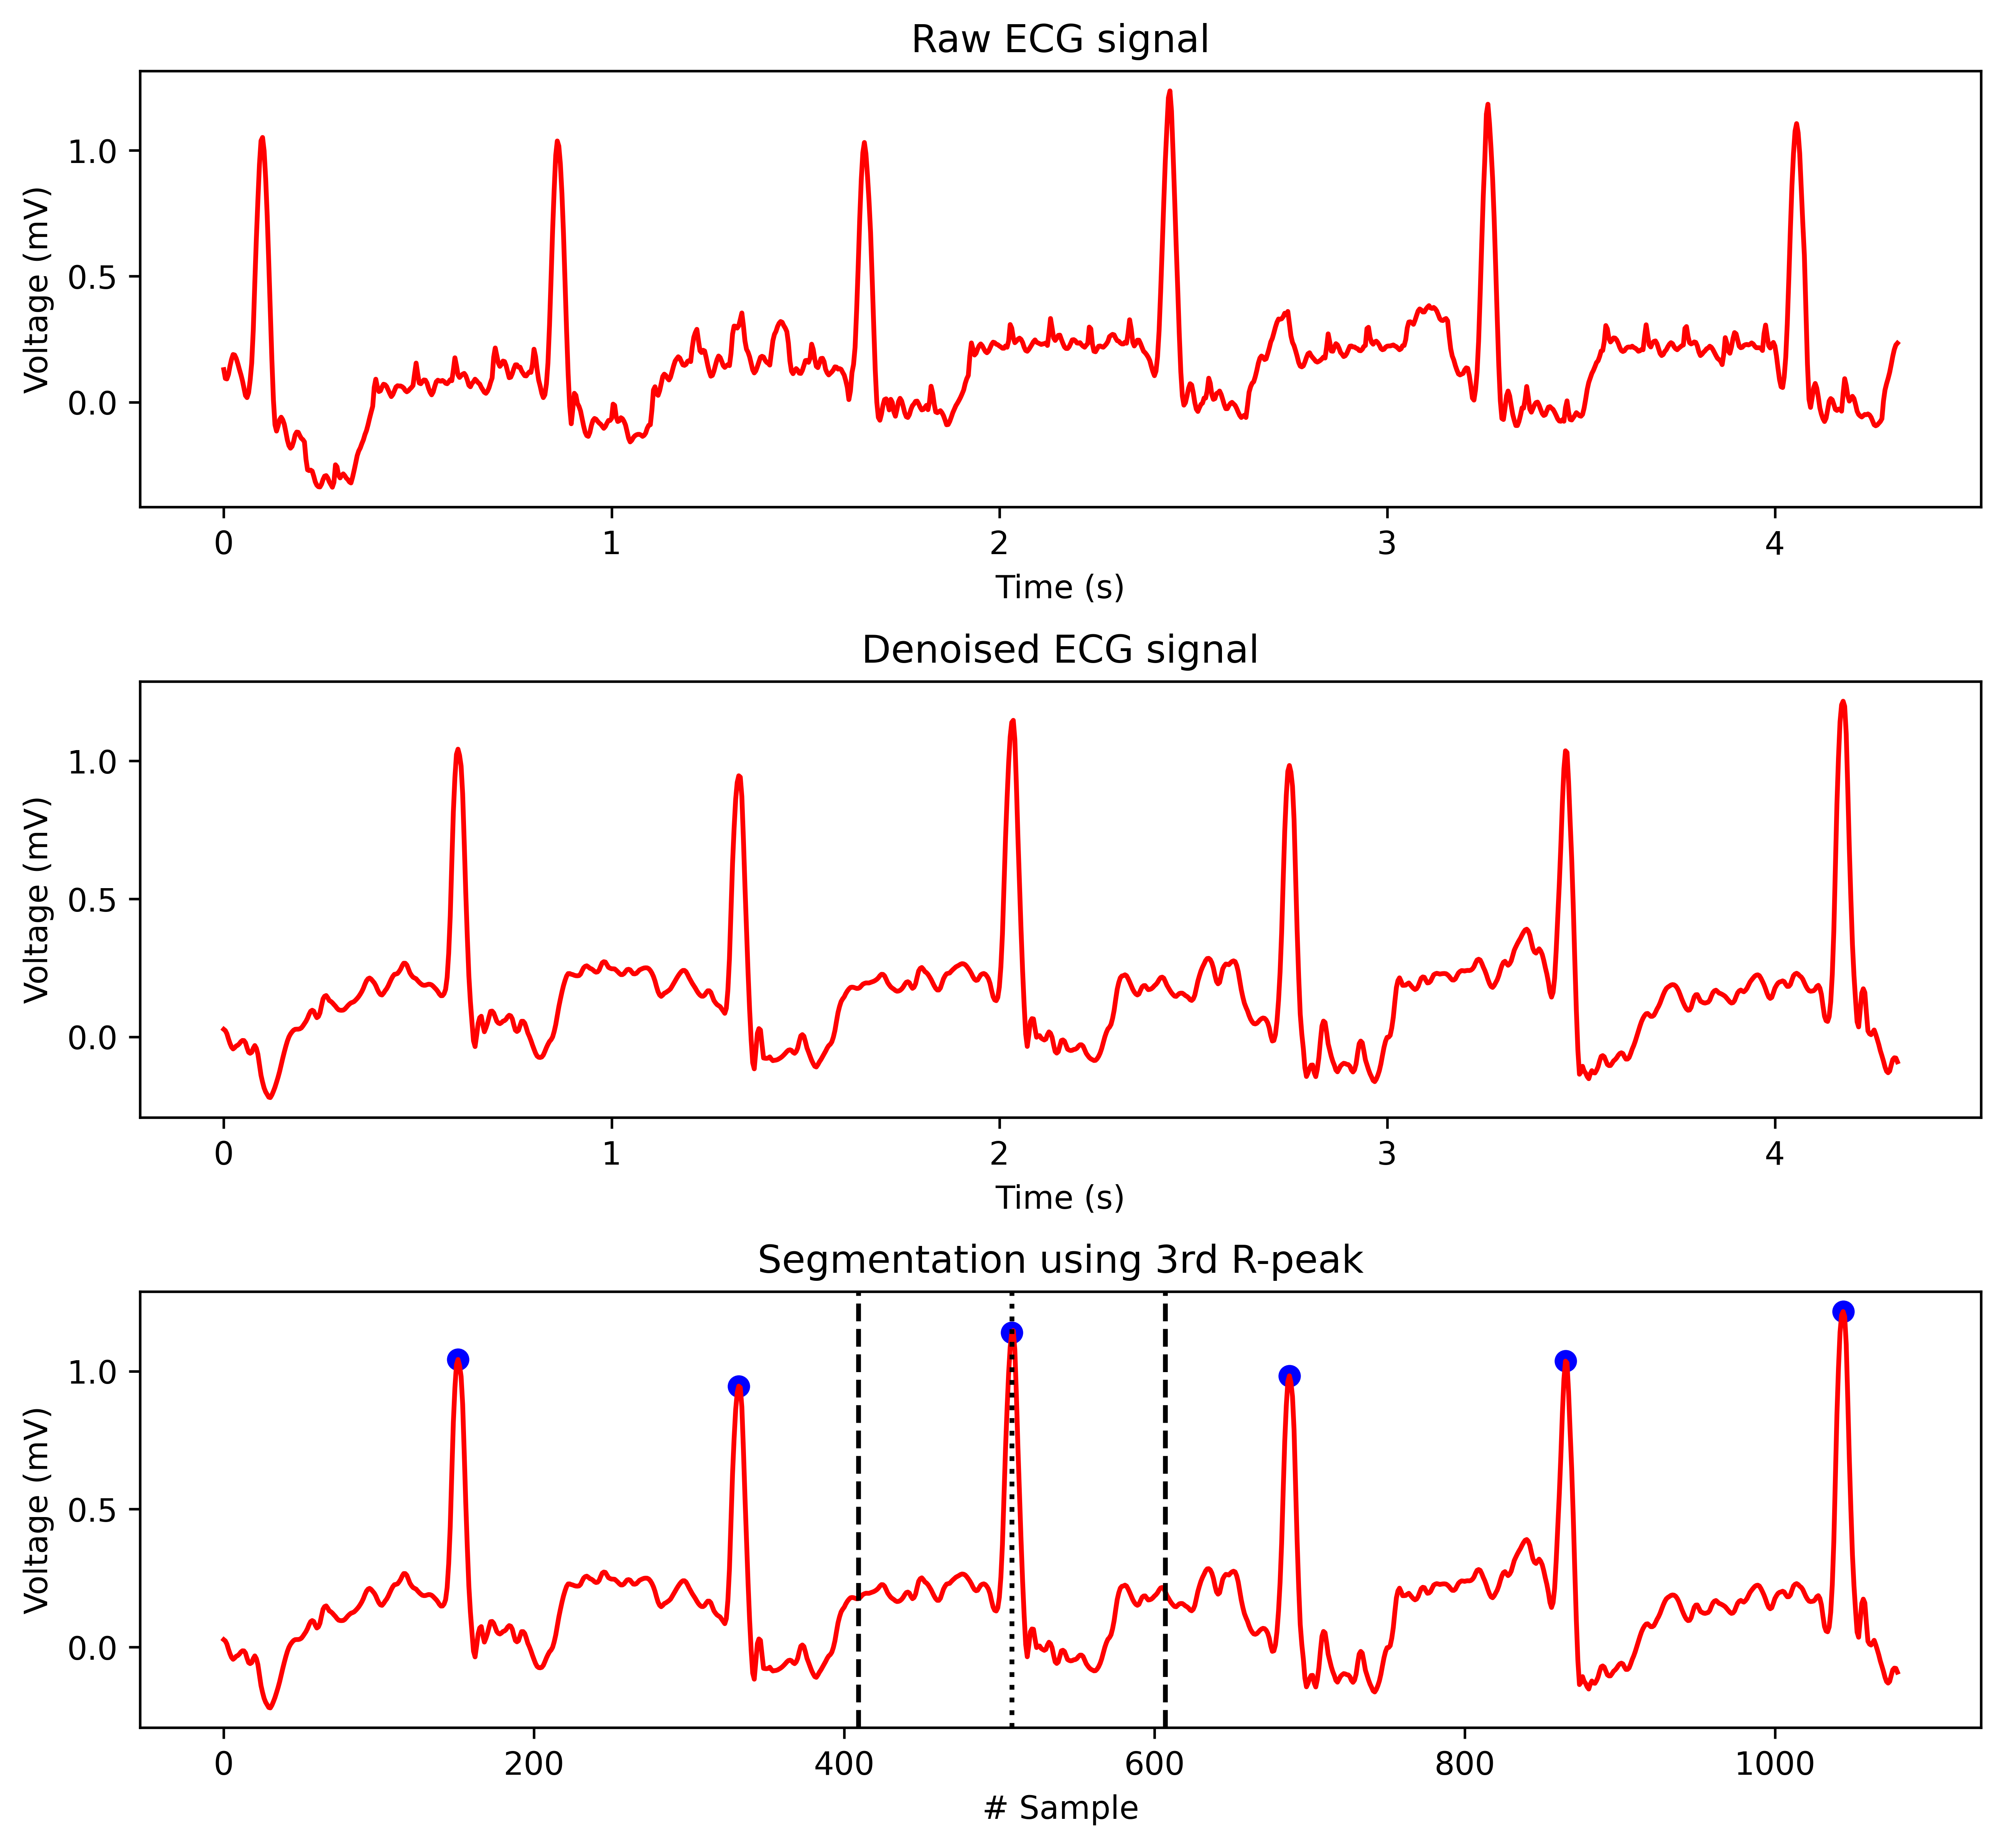

In [12]:
# Vẽ hình ảnh tín hiệu trước, sau khi khử nhiễu và cắt nhịp
fig = plt.figure(figsize=(10,9), dpi=600)
# number of samples to show
n_samples = 1080

# Sampling frequency (use existing fs if available)
sf = globals().get('fs', 250)

# 1) Raw signal: prefer 'readings' (from JSON) or fallback to 'ecg' if available
raw = globals().get('readings', None)
if raw is None:
    raw = globals().get('ecg', None)
if raw is None:
    raise RuntimeError("Raw ECG signal not found (expected variable 'readings' or 'ecg').")

t_raw = np.arange(0, min(n_samples, len(raw))) / sf
plt.subplot(3, 1, 1)
plt.plot(t_raw, raw[:len(t_raw)], color='red')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Raw ECG signal')

# 2) Denoised signal: prefer 'ecg_denoised' or 'rdata'
den = globals().get('ecg_denoised', None)
if den is None:
    den = globals().get('rdata', None)
if den is None:
    raise RuntimeError("Denoised ECG not found (expected 'ecg_denoised' or 'rdata').")

t_den = np.arange(0, min(n_samples, len(den))) / sf
plt.subplot(3, 1, 2)
plt.plot(t_den, den[:len(t_den)], color='red')
plt.title('Denoised ECG signal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')

# 3) Segmentation with R peaks (plot denoised signal and mark peaks)
plt.subplot(3, 1, 3)
display_len = min(n_samples, len(den))
sample_idx = np.arange(display_len)

# Ensure Rlocation is iterable array-like
rl = np.array(Rlocation, dtype=int) if 'Rlocation' in globals() else np.array([])

# filter Rlocation to those inside display range
r_peaks_in_range = [int(p) for p in rl if 0 <= p < display_len]

plt.plot(sample_idx, den[:display_len], color='red')
if len(r_peaks_in_range) > 0:
    plt.scatter(r_peaks_in_range, den[r_peaks_in_range], color='blue')

# Vẽ các đường thẳng chỉ cửa sổ nhịp tim quanh 3rd R-peak (nếu có)
if len(r_peaks_in_range) >= 3:
    rp = r_peaks_in_range[2]
    plt.axvline(x=rp, color='k', linestyle=':')
    plt.axvline(x=max(rp-99, 0), color='k', linestyle='--')
    plt.axvline(x=min(rp+99, display_len-1), color='k', linestyle='--')

plt.xlabel('# Sample')
plt.ylabel('Voltage (mV)')
plt.title('Segmentation using 3rd R-peak')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

figure_path = '/content/gdrive/MyDrive/ECG Arrhythmia trying/Heartbeat_Figures/'
os.makedirs(figure_path, exist_ok=True)  # tạo thư mục nếu chưa có
fig.savefig(os.path.join(figure_path, 'Denoised and segmented ECG.png'))

# **Phần C: Xây dựng MODEL và Training**
**CNN-LSTM và attention** - hybrid model

## **E1: Cơ chế chú ý**
**Convolutional Block Attention Module** ([CBAM](https://arxiv.org/abs/1807.06521)) gồm 2 phần (i) **channel attention**, (ii) spatial attention. ECG là tín hiệu 1 chiều - 1 lead ECG. Do đó, chỉ 1 kênh chú ý được sử dụng.

In [13]:
# udf for channel attention mechanism
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling1D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling1D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])

In [14]:
# udf for spatial attention mechanism
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention]) 

## **E2: Kiến trúc mô hình CNN-LSTM và attention**

### **a. Xây dựng mô hình**

In [15]:
# Build a CNN model
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # The first convolutional layer, sixteen 21x1 convolution kernels
        tf.keras.layers.Conv1D(filters=16, kernel_size=21, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(16, 8),
        # SpatialAttention(7),
        # The first pooling layer, max pooling, 3x1 convolution kernels, stride 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # The second convolution layer, 32 23x1 convolution kernels
        tf.keras.layers.Conv1D(filters=32, kernel_size=23, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(32, 8),
        # SpatialAttention(7),
        # The second pooling layer, max pooling, 3x1 convolution kernels, with a stride of 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # The third convolution layer, 64 25x1 convolution kernels
        tf.keras.layers.Conv1D(filters=64, kernel_size=25, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(64, 8),
        # SpatialAttention(7),
        # The third pooling layer, average pooling, 3x1 convolution kernels, stride 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='SAME'),
        # The fourth convolution layer, 128 27x1 convolution kernels
        tf.keras.layers.Conv1D(filters=128, kernel_size=27, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(128, 8),
        SpatialAttention(7),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(64, return_sequences=True),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # LSTM layer, 32 nodes
        tf.keras.layers.LSTM(32, return_sequences=True),
        # Flatten the layer to facilitate the processing of the fully connected layer
        tf.keras.layers.Flatten(),
        # Fully connected layer, 128 nodes
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # Fully connected layer, 5 nodes
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

### **b. Điều chỉnh các siêu tham số**
* Model: with or without channel or spatial attention.
* CNN Filters: Number of filters in each Conv layer is changing like 4, 16, 32, 64, 128 etc.
* LSTM Units: Number of units of two LSTM layer is varing like 32, 64, 128 etc.

In [16]:
# Build a CNN model
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # The first convolutional layer, four 21x1 convolution kernels
        tf.keras.layers.Conv1D(filters=16, kernel_size=21, strides=1, padding='same', activation='relu'),
        # The first pooling layer, max pooling, four 3x1 convolution kernels, stride 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'),
        # The second convolution layer, 16 23x1 convolution kernels
        tf.keras.layers.Conv1D(filters=32, kernel_size=23, strides=1, padding='same', activation='relu'),
        # The second pooling layer, max pooling, four 3x1 convolution kernels, with a stride of 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'),
        # The third convolution layer, 32 25x1 convolution kernels
        tf.keras.layers.Conv1D(filters=64, kernel_size=25, strides=1, padding='same', activation='relu'),
        # The third pooling layer, average pooling, four 3x1 convolution kernels, stride 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='same'),
        # The fourth convolution layer, 64 27x1 convolution kernels
        tf.keras.layers.Conv1D(filters=128, kernel_size=27, strides=1, padding='same', activation='relu'),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(128, return_sequences=True),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(64, return_sequences=True),
        # Flatten the layer to facilitate the processing of the fully connected layer
        tf.keras.layers.Flatten(),
        # Fully connected layer, 128 nodes
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # Fully connected layer, 5 nodes
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

### **c. Model Training**

**Build, save and then Fit the Model.**
If we have already the saved model, then no need to build, save and fit again.

In [17]:
#Define the log directory, which must be a subdirectory of the specified 
#directory when starting the web application. It is recommended to use date and time as the subdirectory name
logdir = "logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = "ecg_model_code 17_t5.h5"

In [18]:
# percentage of training data used for model validation
ratio = 0.2

In [19]:
if os.path.exists(model_path):
  # Import the trained model
  print('Model is already have in the filepath')
  model = tf.keras.models.load_model(filepath=model_path)
else:
  # Build a CNN model
  print('Model not found, now building and then saving')
  model = buildModel()
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  # Define the TensorBoard object
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
  # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=3)
  checkpoint_filepath="code_17_t5_weights.weights.h5"
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                                 save_weights_only=True, monitor='val_accuracy',
                                                                 mode='max', save_best_only=True)
  callback_list = [tensorboard_callback, model_checkpoint_callback]
  # Training and Validation
  history = model.fit(x_train, y_train, epochs=30,
            batch_size=128,
            validation_split=ratio,
            callbacks=callback_list)
  model.save(filepath=model_path)

Model is already have in the filepath


Số nhịp tim hợp lệ: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
Nhịp 1: N
Nhịp 2: N
Nhịp 3: N
Nhịp 4: N
Nhịp 5: N
Nhịp 6: N


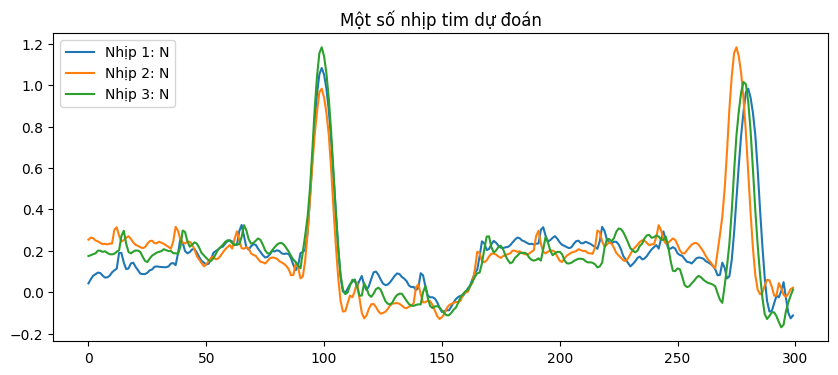

In [20]:
X_test = []
for i in range(len(Rlocation)):
    start = max(Rlocation[i] - 99, 0)
    end = min(Rlocation[i] + 201, len(ecg))
    beat = ecg[start:end]
    if len(beat) < 300:  # bỏ qua nếu thiếu dữ liệu
        continue
    X_test.append(beat)

#chuẩn hóa input về dạng 3 chiều
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)  # [số_nhịp, 300, 1]
print("Số nhịp tim hợp lệ:", len(X_test))

# --- 6. Dự đoán ---
y_pred = model.predict(X_test)
y_class = np.argmax(y_pred, axis=1)

# --- 7. Ánh xạ kết quả ra ký hiệu nhịp ---
classes = ['N', 'S', 'V', 'F', 'Q']
predicted_labels = [classes[i] for i in y_class]

# --- 8. In ra kết quả ---
for i, label in enumerate(predicted_labels[:10]):  # in 10 nhịp đầu tiên
    print(f"Nhịp {i+1}: {label}")

# --- 9. (Tùy chọn) Vẽ minh họa vài nhịp ---
plt.figure(figsize=(10, 4))
for i in range(min(3, len(X_test))):
    plt.plot(X_test[i].squeeze(), label=f'Nhịp {i+1}: {predicted_labels[i]}')
plt.legend()
plt.title("Một số nhịp tim dự đoán")
plt.show()